<a href="https://colab.research.google.com/github/yoichinaka/card-fraud-detection-by-logistic-regression/blob/master/week3_%E3%81%AE%E3%82%B3%E3%83%94%E3%83%BC2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import time
import datetime
import json
import gc
from numba import jit

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook

import lightgbm as lgb
import xgboost as xgb
#from catboost import CatBoostRegressor, CatBoostClassifier

from sklearn import metrics
from sklearn import preprocessing
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression

from itertools import product

import altair as alt
from altair.vega import v5
from IPython.display import HTML

In [0]:
train_identity = pd.read_csv('train_identity.csv')
train_transaction = pd.read_csv('train_transaction.csv')
test_identity = pd.read_csv('test_identity.csv')
test_transaction = pd.read_csv('test_transaction.csv')
#sub = pd.read_csv('sample_submission.csv')
# let's combine the data and work with the whole dataset
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

In [0]:
X = train.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1)
y = train.sort_values('TransactionDT')['isFraud']
X_test = test.sort_values('TransactionDT').drop(['TransactionDT', 'TransactionID'], axis=1)

In [142]:
X.shape, X_test.shape, y.shape, 

((21973, 431), (21077, 431), (21973,))

# X is train data wiht 21973 raw data and 431 categolies, y is Fraund or not data, X_test is test data


# There are 620 frauds in X(train data).

In [143]:
list(y ==1).count(True)

620

In [168]:
print('percent of fraud is', 620/21973*100)

percent of fraud is 2.821644745824421


In [144]:
X.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,...,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


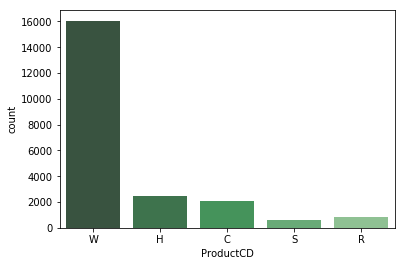

In [145]:
sns.countplot(x='ProductCD', data=X, palette='Greens_d')

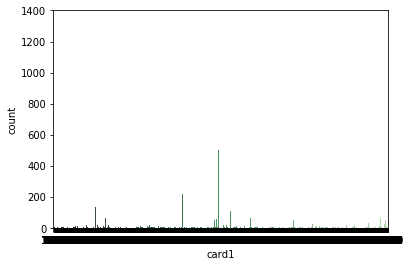

In [146]:
sns.countplot(x='card1', data=X, palette='Greens_d')

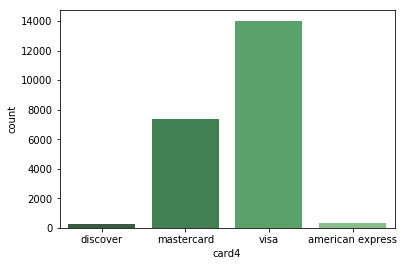

In [147]:
sns.countplot(x='card4', data=X, palette='Greens_d')

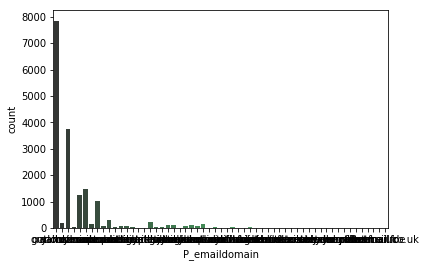

In [148]:
sns.countplot(x='P_emaildomain', data=X, palette='Greens_d')

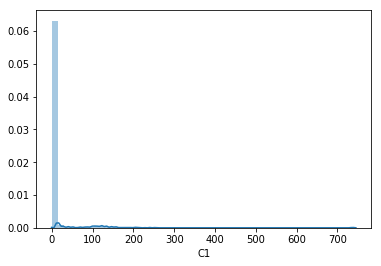

In [149]:
sns.distplot(X.C1,kde = True)

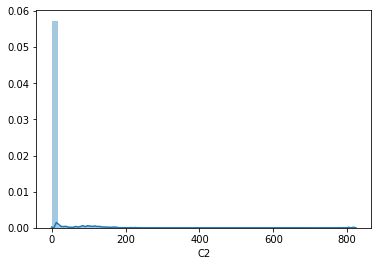

In [150]:
sns.distplot(X.C2,kde = True)

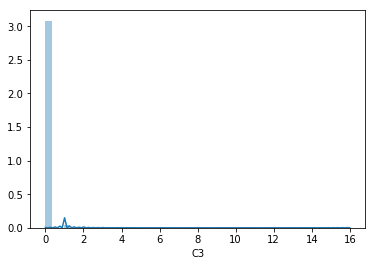

In [151]:
sns.distplot(X.C3,kde = True)

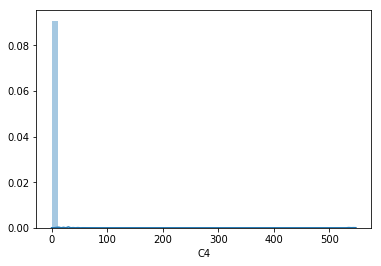

In [152]:
sns.distplot(X.C4,kde = True)

# Transform categorical data to numer.

In [0]:
cat_cols = ['id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29',
            'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'ProductCD', 'card4', 'card6', 'M4','P_emaildomain',
            'R_emaildomain', 'card1', 'card2', 'card3',  'card5', 'addr1', 'addr2', 'M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9',
            'P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3', 'R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']
for col in cat_cols:
    if col in train.columns:
        le = preprocessing.LabelEncoder()
        le.fit(list(X[col].astype(str).values) + list(X_test[col].astype(str).values))
        X[col] = le.transform(list(X[col].astype(str).values))
        X_test[col] = le.transform(list(X_test[col].astype(str).values))  

In [154]:
X.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,...,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,68.5,4,1258,498,26,1,20,0,64,21,19.0,NaN,32,31,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,30,17,3,2,45,11,300,156,72,6,3,7,66,38,2,2,2,74,81,3,102,3,2,2,2,2,2,501
1,29.0,4,2865,303,26,2,1,0,66,21,NaN,NaN,16,31,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,30,17,3,2,45,11,300,156,72,6,3,7,66,38,2,2,2,74,81,3,102,3,2,2,2,2,2,501
2,59.0,4,3387,389,26,4,31,1,68,21,287.0,NaN,36,31,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,30,17,3,2,45,11,300,156,72,6,3,7,66,38,2,2,2,74,81,3,102,3,2,2,2,2,2,501
3,50.0,4,2527,465,26,2,4,1,112,21,NaN,NaN,54,31,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,30,17,3,2,45,11,300,156,72,6,3,7,66,38,2,2,2,74,81,3,102,3,2,2,2,2,2,501
4,50.0,1,3340,413,26,2,1,0,93,21,NaN,NaN,16,31,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,1,30,5,1,1,27,11,231,12,72,6,3,7,66,38,2,1,1,7,97,2,66,2,1,0,1,1,1,256


# Remove the columns that have over 90% null cells.

In [155]:
many_null_cols = [col for col in X.columns if X[col].isnull().sum() / X.shape[0] > 0.9]
many_null_cols_test = [col for col in X_test.columns if X_test[col].isnull().sum() / X_test.shape[0] > 0.9]
cols_to_drop = list(set(many_null_cols + many_null_cols_test ))
len(cols_to_drop)

61

In [0]:
X = X.drop(cols_to_drop, axis=1)
X_test = X_test.drop(cols_to_drop, axis=1)

In [157]:
X.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D10,D11,D15,M1,M2,M3,M4,M5,...,V316,V317,V318,V319,V320,V321,id_01,id_02,id_05,id_06,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,68.5,4,1258,498,26,1,20,0,64,21,19.0,32,31,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,13.0,13.0,0.0,0,1,1,2,0,...,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,2,30,17,3,2,45,11,300,156,72,6,3,7,66,38,2,2,2,74,81,3,102,3,2,2,2,2,2,501
1,29.0,4,2865,303,26,2,1,0,66,21,NaN,16,31,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,0.0,1,2,2,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,2,30,17,3,2,45,11,300,156,72,6,3,7,66,38,2,2,2,74,81,3,102,3,2,2,2,2,2,501
2,59.0,4,3387,389,26,4,31,1,68,21,287.0,36,31,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,315.0,315.0,0,1,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,2,30,17,3,2,45,11,300,156,72,6,3,7,66,38,2,2,2,74,81,3,102,3,2,2,2,2,2,501
3,50.0,4,2527,465,26,2,4,1,112,21,NaN,54,31,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,84.0,NaN,111.0,1,2,2,0,1,...,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,2,30,17,3,2,45,11,300,156,72,6,3,7,66,38,2,2,2,74,81,3,102,3,2,2,2,2,2,501
4,50.0,1,3340,413,26,2,1,0,93,21,NaN,16,31,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2,2,3,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70787.0,NaN,NaN,100.0,1,30,5,1,1,27,11,231,12,72,6,3,7,66,38,2,1,1,7,97,2,66,2,1,0,1,1,1,256


In [0]:
# by https://www.kaggle.com/dimartinot
def clean_inf_nan(df):
    return df.replace([np.inf, -np.inf], np.nan)   

# Cleaning infinite values to NaN
X = clean_inf_nan(X)
X_test = clean_inf_nan(X_test )

# Fill NaN by means value

In [0]:
X = X.fillna(X.mean())
X_test = X_test.fillna(X_test.mean())

In [160]:
X.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D10,D11,D15,M1,M2,M3,M4,M5,...,V316,V317,V318,V319,V320,V321,id_01,id_02,id_05,id_06,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,68.5,4,1258,498,26,1,20,0,64,21,19.000000,32,31,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,169.456529,13.000000,155.369202,35.500139,13.000000,13.000000,0.000000,0,1,1,2,0,...,0.0,117.0,0.0,0.0,0.0,0.0,-8.270124,135613.178163,1.702406,-5.797878,99.632968,2,30,17,3,2,45,11,300,156,72,6,3,7,66,38,2,2,2,74,81,3,102,3,2,2,2,2,2,501
1,29.0,4,2865,303,26,2,1,0,66,21,121.249834,16,31,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,169.456529,27.021208,0.000000,35.500139,0.000000,141.593004,0.000000,1,2,2,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,-8.270124,135613.178163,1.702406,-5.797878,99.632968,2,30,17,3,2,45,11,300,156,72,6,3,7,66,38,2,2,2,74,81,3,102,3,2,2,2,2,2,501
2,59.0,4,3387,389,26,4,31,1,68,21,287.000000,36,31,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,169.456529,27.021208,0.000000,35.500139,0.000000,315.000000,315.000000,0,1,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,-8.270124,135613.178163,1.702406,-5.797878,99.632968,2,30,17,3,2,45,11,300,156,72,6,3,7,66,38,2,2,2,74,81,3,102,3,2,2,2,2,2,501
3,50.0,4,2527,465,26,2,4,1,112,21,121.249834,54,31,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.000000,0.000000,94.000000,0.000000,84.000000,141.593004,111.000000,1,2,2,0,1,...,50.0,1404.0,790.0,0.0,0.0,0.0,-8.270124,135613.178163,1.702406,-5.797878,99.632968,2,30,17,3,2,45,11,300,156,72,6,3,7,66,38,2,2,2,74,81,3,102,3,2,2,2,2,2,501
4,50.0,1,3340,413,26,2,1,0,93,21,121.249834,16,31,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,169.456529,27.021208,155.369202,35.500139,127.479675,141.593004,179.688591,1,2,2,3,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,70787.000000,1.702406,-5.797878,100.000000,1,30,5,1,1,27,11,231,12,72,6,3,7,66,38,2,1,1,7,97,2,66,2,1,0,1,1,1,256


# Make Logisitic regression model and predict

In [161]:
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [0]:
#print("coefficient = ", clf.coef_)
#print("intercept = ", clf.intercept_)

In [163]:
Y_pred = clf.predict(X_test)
len(Y_pred)

21077

# Classfier predicts 40 frauds from test data.

In [164]:
a = (Y_pred == 1)
b= list(a)
b.count(True)

40

In [165]:
c =[c for c, x in enumerate(b) if x == True]
print(c)
len(c)

[752, 2465, 3602, 3608, 4120, 4228, 4524, 4533, 5435, 6173, 6207, 6209, 6373, 6685, 6752, 8189, 8190, 9468, 9478, 9765, 9769, 9777, 9781, 9782, 9812, 9839, 9840, 9844, 9847, 9849, 11273, 14371, 14931, 15071, 17059, 17357, 17359, 19539, 19541, 19834]


40

In [169]:
print('percent of predicted fraud ', 40/21077*100)

percent of predicted fraud  0.18978032926887128
